<a href="https://colab.research.google.com/github/Int-Group-44/flowers-102/blob/main/OxfordFlowers102CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
dataset_info
test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']

In [3]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

print(gpus)

Physical devices cannot be modified after being initialized
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Importing TensorFlow 

In [4]:
num_classes = dataset_info.features['label'].num_classes
num_training_examples = 1020
num_validation_examples = 1020

In [5]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    #label = tf.one_hot(label, depth=num_classes)
    return image, label
BATCH_SIZE = 16
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.shuffle(num_validation_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_set.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [22]:
def make_model(input_shape, num_classes):
  model = tf.keras.Sequential()
  model.add(layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape))
  model.add(layers.RandomRotation(20))
  model.add(layers.RandomZoom(0.2))
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(num_classes))
  return model


In [33]:
tf.keras.backend.clear_session()
model = make_model(input_shape=(IMAGE_RES, IMAGE_RES) + (3,), num_classes=102)

In [34]:

#keras.utils.plot_model(model, show_shapes=True)

epochs = 50

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/50
64/64 [==============================] - 18s 153ms/step - loss: 5.8945 - accuracy: 0.0147 - val_loss: 4.7008 - val_accuracy: 0.0098
Epoch 2/50
64/64 [==============================] - 10s 147ms/step - loss: 4.9362 - accuracy: 0.0235 - val_loss: 4.8379 - val_accuracy: 0.0098
Epoch 3/50
64/64 [==============================] - 12s 187ms/step - loss: 4.8400 - accuracy: 0.0196 - val_loss: 4.9424 - val_accuracy: 0.0098
Epoch 4/50
64/64 [==============================] - 10s 156ms/step - loss: 4.7150 - accuracy: 0.0333 - val_loss: 4.7216 - val_accuracy: 0.0176
Epoch 5/50
64/64 [==============================] - 10s 146ms/step - loss: 4.6353 - accuracy: 0.0314 - val_loss: 4.6264 - val_accuracy: 0.0118
Epoch 6/50
64/64 [==============================] - 10s 148ms/step - loss: 4.6034 - accuracy: 0.0176 - val_loss: 4.6079 - val_accuracy: 0.0235
Epoch 7/50
64/64 [==============================] - 10s 150ms/step - loss: 4.5989 - accuracy: 0.0245 - val_loss: 4.5635 - val_accuracy: 0.0137

In [35]:
tloss1 = history.history['loss']
vloss1 = history.history['val_loss']
tacc1 = history.history['accuracy']
vacc1 = history.history['val_accuracy']

In [36]:

#keras.utils.plot_model(model, show_shapes=True)

epochs = 50

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/50
64/64 [==============================] - 19s 157ms/step - loss: 2.7713 - accuracy: 0.2725 - val_loss: 3.0086 - val_accuracy: 0.2804
Epoch 2/50
64/64 [==============================] - 9s 143ms/step - loss: 2.6842 - accuracy: 0.2961 - val_loss: 2.8714 - val_accuracy: 0.2990
Epoch 3/50
64/64 [==============================] - 9s 139ms/step - loss: 2.5832 - accuracy: 0.3167 - val_loss: 2.9533 - val_accuracy: 0.2892
Epoch 4/50
64/64 [==============================] - 9s 138ms/step - loss: 2.4890 - accuracy: 0.3186 - val_loss: 2.9420 - val_accuracy: 0.2686
Epoch 5/50
64/64 [==============================] - 10s 144ms/step - loss: 2.5125 - accuracy: 0.3108 - val_loss: 2.8702 - val_accuracy: 0.2814
Epoch 6/50
64/64 [==============================] - 9s 143ms/step - loss: 2.4702 - accuracy: 0.3431 - val_loss: 2.8429 - val_accuracy: 0.3020
Epoch 7/50
64/64 [==============================] - 9s 143ms/step - loss: 2.4589 - accuracy: 0.3392 - val_loss: 2.8819 - val_accuracy: 0.3059
Epoc

In [37]:
tloss2 = history.history['loss']
vloss2 = history.history['val_loss']
tacc2 = history.history['accuracy']
vacc2 = history.history['val_accuracy']

In [38]:
#keras.utils.plot_model(model, show_shapes=True)

epochs = 50

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000025),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/50
64/64 [==============================] - 19s 146ms/step - loss: 1.4818 - accuracy: 0.5647 - val_loss: 2.8198 - val_accuracy: 0.3951
Epoch 2/50
64/64 [==============================] - 10s 151ms/step - loss: 1.3833 - accuracy: 0.5863 - val_loss: 2.8100 - val_accuracy: 0.4020
Epoch 3/50
64/64 [==============================] - 9s 140ms/step - loss: 1.3329 - accuracy: 0.5980 - val_loss: 2.7874 - val_accuracy: 0.4000
Epoch 4/50
64/64 [==============================] - 10s 141ms/step - loss: 1.3281 - accuracy: 0.5951 - val_loss: 2.8052 - val_accuracy: 0.3922
Epoch 5/50
64/64 [==============================] - 9s 144ms/step - loss: 1.3060 - accuracy: 0.6324 - val_loss: 2.7901 - val_accuracy: 0.4157
Epoch 6/50
64/64 [==============================] - 10s 145ms/step - loss: 1.3716 - accuracy: 0.5824 - val_loss: 2.8206 - val_accuracy: 0.4020
Epoch 7/50
64/64 [==============================] - 9s 143ms/step - loss: 1.2366 - accuracy: 0.6147 - val_loss: 2.7543 - val_accuracy: 0.4147
Ep

In [39]:
tloss3 = history.history['loss']
vloss3 = history.history['val_loss']
tacc3 = history.history['accuracy']
vacc3 = history.history['val_accuracy']

In [ ]:
model.save('OxfordFlowers102-2.keras')

In [40]:
test_loss, test_acc = model.evaluate(test_batches, verbose=1, batch_size=BATCH_SIZE)
print("Test accuracy:", test_acc)

385/385 [==============================] - 13s 34ms/step - loss: 3.4175 - accuracy: 0.3737
Test accuracy: 0.37371930480003357


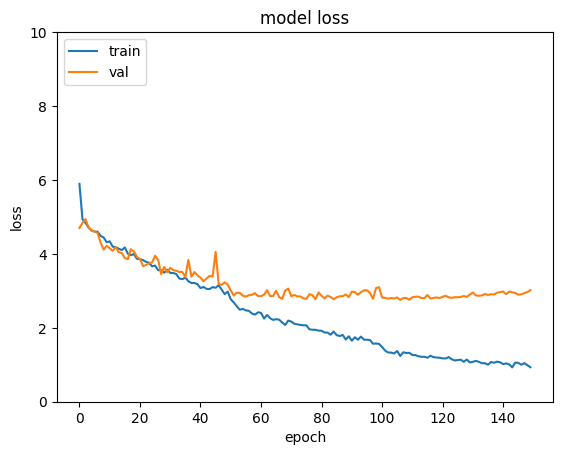

In [41]:
plt.plot(tloss1+tloss2+tloss3)
plt.ylim(0,10)
plt.plot(vloss1+vloss2+vloss3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc="upper left")
plt.show()

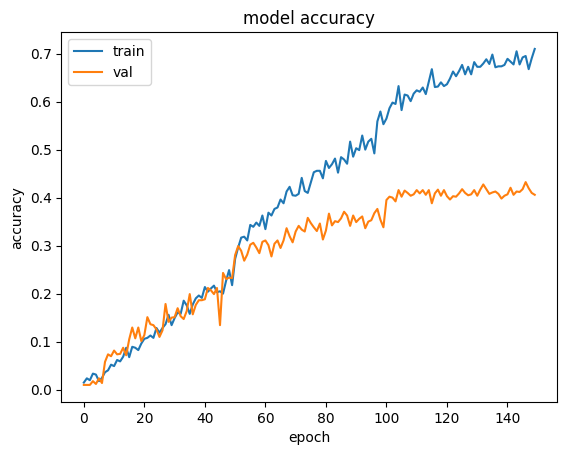

In [42]:
plt.plot(tacc1+tacc2+tacc3)
plt.plot(vacc1+vacc2+vacc3)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc="upper left")
plt.show()